# Project: ICD-AIS conversion using Deep Learning

### This script creates sparse matrices for the input and output files and creates a neural net using that data

## Setup

In [52]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import time

import modules.helper_functions_800 as hlp

In [19]:
ais_train_file = "../Data/train_ais_agecat_I9_A05.csv"
icd_train_file ="../Data/train_icd_agecat_I9_A05.csv"
ais_val_file = "../Data/val_ais_agecat_I9_A05.csv"
icd_val_file ="../Data/val_icd_agecat_I9_A05.csv"
ais_test_file = "../Data/test_ais_agecat_I9_A05.csv"
icd_test_file ="../Data/test_icd_agecat_I9_A05.csv"
ais_codes_file = "../Data/AIS08_codes.csv"

## Load data

In [20]:
icd_train = pd.read_csv(icd_train_file, header=None, names=["icd_code"])
icd_val = pd.read_csv(icd_val_file, header=None, names=["icd_code"])
icd_test = pd.read_csv(icd_test_file, header=None, names=["icd_code"])
ais_train = pd.read_csv(ais_train_file, header=None, names=["icd_code"])
ais_val = pd.read_csv(ais_val_file, header=None, names=["icd_code"])
ais_test = pd.read_csv(ais_test_file, header=None, names=["icd_code"])

# load AIS codes
ais_map = pd.read_csv(ais_codes_file, header=0, encoding='iso-8859-1')

## Retrieve all data to train the neural net

### Only use this if you want to skip to [creating a neural net](#neural_net) with a new kernel as opposed to running the whole notebook again.

In [21]:
%store -r icd_codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

%store -r ais_codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

%store -r sparse_icd_train
%store -r sparse_icd_test
%store -r sparse_icd_val

%store -r sparse_ais_train
%store -r sparse_ais_test
%store -r sparse_ais_val

## Extract all unique patient ICD and AIS codes

In [4]:
%%time
# get unique icd codes from all sets
icd_codes = hlp.get_unique_codes([icd_train, icd_val, icd_test])
%store icd_codes

CPU times: user 5min 58s, sys: 621 ms, total: 5min 59s
Wall time: 6min


In [7]:
# create dictionary of ICD codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

In [8]:
%%time
# get unique ais codes from all sets
ais_codes = hlp.get_unique_codes([ais_train, ais_val, ais_test])
%store ais_codes

CPU times: user 4min 46s, sys: 97.9 ms, total: 4min 46s
Wall time: 4min 46s


In [6]:
# create dictionary of AIS codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

## Create sparse matrices

### Create training, testing, and validation ICD matrices

In [57]:
%%time
for

row, col, data = hlp.decode_df_coo(icd_train, icd_dict)
sparse_icd_train = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
row, col, data = hlp.decode_df_coo(icd_test, icd_dict)
sparse_icd_test = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)

row, col, data = hlp.decode_df_coo(icd_val, icd_dict)
sparse_icd_val = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)

%store sparse_icd_train
%store sparse_icd_test
%store sparse_icd_val

Stored 'sparse_icd_train' (Tensor)
Stored 'sparse_icd_test' (Tensor)
Stored 'sparse_icd_val' (Tensor)
CPU times: user 4min 36s, sys: 2.61 s, total: 4min 39s
Wall time: 4min 41s


### Create training, testing, and validation AIS matrices

In [33]:
%%time
row, col, data = hlp.decode_df_coo(ais_train, ais_dict)
sparse_ais_train = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)

row, col, data = hlp.decode_df_coo(ais_test, ais_dict)
sparse_ais_test = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)

row, col, data = hlp.decode_df_coo(ais_val, ais_dict)
sparse_ais_val = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)

%store sparse_ais_train
%store sparse_ais_test
%store sparse_ais_val

Stored 'sparse_ais_train' (Tensor)
Stored 'sparse_ais_test' (Tensor)
Stored 'sparse_ais_val' (Tensor)
CPU times: user 4min 31s, sys: 729 ms, total: 4min 32s
Wall time: 4min 32s


## Test validity of create sparse matrices

In [13]:
%%time

# Create inverted dicts to test validity
icd_inverted_dict = {v: k for k, v in icd_dict.items()}
ais_inverted_dict = {v: k for k, v in ais_dict.items()}

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.54 ms


In [21]:
%%time

# This takes over an hour to run... will do 10k at random instead
ne, matrix_df = hlp.test_sparse_matrix(sparse_icd_train, icd_train, icd_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 5.51 s, sys: 62.2 ms, total: 5.58 s
Wall time: 1.86 s


In [22]:
%%time
ne, matrix_df = hlp.test_sparse_matrix(sparse_icd_test, icd_test, icd_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 6min 49s, sys: 5.71 s, total: 6min 55s
Wall time: 2min 30s


In [23]:
%%time
ne, matrix_df = hlp.test_sparse_matrix(sparse_icd_val, icd_val, icd_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 647 ms, sys: 39 ms, total: 686 ms
Wall time: 344 ms


In [24]:
%%time

ne, matrix_df = hlp.test_sparse_matrix(sparse_ais_train, ais_train, ais_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 1.27 s, sys: 22 ms, total: 1.29 s
Wall time: 430 ms


In [25]:
%%time
ne, matrix_df = hlp.test_sparse_matrix(sparse_ais_test, ais_test, ais_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 2min 21s, sys: 1.81 s, total: 2min 23s
Wall time: 48 s


In [26]:
%%time
ne, matrix_df = hlp.test_sparse_matrix(sparse_ais_val, ais_val, ais_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 514 ms, sys: 30 ms, total: 544 ms
Wall time: 200 ms


<a id='neural_net'></a>
## Set up neural net training

In [45]:
# Set parameters...
# For training
learning_rate = 0.0015
batch_size = 16000 # Try increasing could speed it up
num_epochs = 10
# For neural net
input_size = len(icd_dict)
num_classes = len(ais_dict)

In [46]:
# Try to run on GPU else run on CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

Using cuda device


### Create a neural net class

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__() # Init the superclass nn.Module
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, int(input_size/4)),
            nn.ReLU(),
            nn.Linear(int(input_size/4), num_classes),
            nn.ReLU(),
            # find a function to keep between 0-1
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Create a dataset and a dataloader

In [57]:
class SparseMatrixDataset(Dataset):
    def __init__(self, sparse_icd, sparse_ais, divisor):
        self.icd = sparse_icd.to('cuda')
        self.ais = sparse_ais.to('cuda')
        self.divisor = divisor
        self.current_row = 0
        self.count = 1
        self.length = 0

    def __len__(self):
        length = int(math.ceil(len(self.icd)/(batch_size * self.divisor)))
        self.length = length
        return length
    
    def __getitem__(self, idx):        
        # Get indices for icd and ais and return
        end = self.current_row + batch_size
        if end >= len(self.icd):
            end = len(self.icd)
        spliced_icd_matrix = hlp.get_dense_submat(sparse_icd_train, self.current_row, end)
        spliced_ais_matrix = hlp.get_dense_submat(sparse_ais_train, self.current_row, end)
        self.current_row = end
        print((str(self.count) + " / " + str(self.length)), end="\r")
        self.count += 1
        return spliced_icd_matrix, spliced_ais_matrix

In [58]:
# Create dataloader using dataset
train_loader = DataLoader(dataset=SparseMatrixDataset(sparse_icd_train, sparse_ais_train, 1), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=SparseMatrixDataset(sparse_icd_val, sparse_ais_val, 1), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=SparseMatrixDataset(sparse_icd_test, sparse_ais_test, 1), batch_size=batch_size, shuffle=True)

Time to splice icd matrix: 289.75277403199993


KeyboardInterrupt: 

## Creating a neural net and training it

### Create the model and set up training

In [50]:
# Init network
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device) # You can store

# Set loss and optimizer
loss_function = nn.BCELoss() #nn.MSELoss() Binary cross entropy seems to be the best
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Neural Net

In [53]:
%%time
# train_test_split, stratify by ais codes???
# Flag to let us know if this is the first save of the model
first_save = True
# Train network
val_losses = [] # List of losses from each of the past epochs
for epoch in range(num_epochs):
    print('Starting epoch #' + str(epoch+1) + '...')
    print('Training data...')
    for batch_index, (icd_batch, ais_batch) in enumerate((train_loader)):
        # forward
        start = time.process_time()
        scores = model(icd_batch.cuda())
        print("Time to get scores: " + str(time.process_time() - start))
        start = time.process_time()
        loss = loss_function(scores, ais_batch.cuda())
        print("Time to get loss: " + str(time.process_time() - start))
        del icd_batch
        del ais_batch
        del scores
        # backward
        start = time.process_time()
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        print("Time for backwards propagation: " + str(time.process_time() - start))
    print('Loss at epoch number ' + str(epoch+1) + ' is ' + str(float(loss)))
     
    print('Validating data...')
    new_val_losses = [] # List of losses for this epoch      
    # Validation data don't train, just see where u are after each epoch # When validating round up/down
    for batch_index, (icd_batch, ais_batch) in enumerate((val_loader)):
        # forward
        scores = model(icd_batch.cuda())
        loss = loss_function(scores, ais_batch.cuda())
        new_val_losses.append(loss.item())
        del icd_batch
        del ais_batch
        del scores
        del loss
    
    # Check if we are getting a less accurate model
    if len(val_losses) > 0:
        if hlp.get_list_avg(new_val_losses) > hlp.get_list_avg(val_losses):
            print("Model is worsening... early stopping")
            model = torch.load(PATH)
            break
        else:
            print("Model continuing to improve... saving state")
            # Then save the model
            if first_save:
                # Store trained model for the first time
                # https://stackoverflow.com/a/43819235/16393363
                torch.save(model.state_dict(), PATH)
                # Load for the first time
                model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
                model.load_state_dict(torch.load(PATH))
            else: 
                # Save entire model
                torch.save(model, PATH)
                model = torch.load(PATH)
            val_losses.append(new_val_losses)
    else:
        val_losses.append(new_val_losses)


Starting epoch #1...
Training data...
Time to splice icd matrix: 289.9706738499999
Time to splice ais matrix: 86.6393388009999


KeyboardInterrupt: 

In [ ]:
# Load model and test
model = torch.load(PATH)
print('Testing data...')
for batch_index, (icd_batch, ais_batch) in enumerate((test_loader)):
    # forward
    scores = model(icd_batch.cuda())
    scores = (scores>0.5).float() # Set scores over 0.5 to 1 else 0
    # Create a dataframe from the information that we have!

### Store and load model for the first time

#### Store

In [53]:
# Set path to store model at
PATH = '/home/qdy4zt/ICD_to_AIS_playground/Models/one-batch-model'

In [54]:
# Store trained model for the first time
# https://stackoverflow.com/a/43819235/16393363
torch.save(model.state_dict(), PATH)

#### Load

In [55]:
# Load for the first time
model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Store and load model after first store/load

#### Store

In [56]:
# Save entire model
torch.save(model, PATH)

#### Load

In [57]:
model = torch.load(PATH)

## Evaluate the trained neural net

### Analyze losses

In [58]:
%store losses

Stored 'losses' (list)


In [59]:
%store -r losses

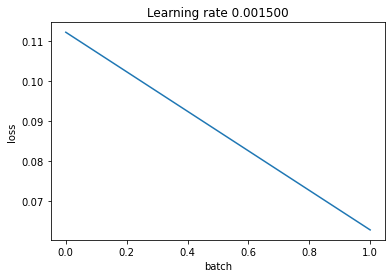

In [60]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('batch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

### Check accuracy

In [33]:
divisor = 900 # Set to 1 to run for all data

# Function that gets submatrix in dense format
def get_dense_submat(full_sparse_mat, start, end, ais=False):
    try:
        if ais == False:
            return torch.index_select(full_sparse_mat.cuda(),0,torch.tensor(list(range(start, end))).cuda()).to_dense()
        else:
            raise("Not sure what's going on")
    except:
        return torch.index_select(full_sparse_mat.cuda(),0,torch.tensor(list(range(start, end))).cuda())

    
    
    
# Okay all of this is junk im going to start over
# What I think I need:
#   - Get predictions for each patient
#   - Get the ais codes for each patient
#   - Compare those, then incr  
    
# Check accuracy on training & test to see how good our model
def check_accuracy(sparse_icd, sparse_ais, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    # Keep track of where we are
    current_row = 0
    end = 1983
    # Transfer to GPU
    sparse_icd, sparse_ais = sparse_icd.to(device), sparse_ais.to(device)
    with torch.no_grad():
        # While current row isn't higher than the desired length
        while not current_row >= (len(sparse_icd) / (divisor * batch_size)):
            # Get predictions
            scores = model(get_dense_submat(sparse_icd, current_row, end).cuda())
            _, predictions = scores.max(1)
            predictions = predictions.to(device)

            
            dense_pred = get_dense_submat(predictions, current_row, end)
            dense_ais = get_dense_submat(sparse_ais, current_row, end, ais=True)
            # For row in batch
            for row in range(current_row, end):
                print(dense_pred)
                print(dense_ais)
                # If prediction matches sparse ais, add another correct
                num_correct += (dense_pred[row] == 
                                dense_ais[row])
                num_samples += predictions.size(0)
                return 'done'
            current_row = end
            # If end is greater than the length we are trying to go to, just set end to that length
            if end >= (len(sparse_icd) / (divisor * batch_size)):
                end = (len(sparse_icd) / (divisor * batch_size))
            end += 1983

    model.train()
    return num_correct/num_samples

print(f"Accuracy on training set: ")
print(check_accuracy(sparse_icd_train, sparse_ais_train, model)*100)
print(f"Accuracy on test set: ")
print(check_accuracy(sparse_icd_test, sparse_ais_test, model)*100)

Accuracy on training set: 


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper__addmm)